## Introduction

In this post, I want to show you how to create the diagrams I made for [my post on terrorism]({filename}/blog/terrorism.md). I used Python 3.4 with the following packages:

- IPython Notebook (Jupyter)
- Matplotlib
- Pandas
- Seaborn

(you can install all of this via PyPi's package manager ``pip``)

Actually, this post itself is an IPython notebook. You can download the source code at the bottom of this page, and play around with the data and the plots yourself! Just make sure you save the filw with a .ipynb extension.

## Let's get started

First, we will import some packages:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

### Read data

I have downloaded the data I want to use from [Eurostat](http://appsso.eurostat.ec.europa.eu/nui/show.do?dataset=hlth_cd_asdr2&lang=en). You can go ahead, change the contents of the data, and download it yourself, or [use the data I used]({filename}/downloads/hlth_cd_asdr2_1_Data.csv). Either way, let's read it into pandas and have a look at the first 5 entries, and the data that is contained in the columns:

In [2]:
data = pd.read_csv("../downloads/hlth_cd_asdr2_1_Data.csv")
print(data[:5])

time_range = set(data.TIME)
countries = set(data.GEO)
ages = set(data.AGE)
death_causes = set(data.ICD10)

print("\nTime range: " + ", ".join(str(x) for x in time_range))
print("\nCountries: " + ", ".join(str(x) for x in countries))
print("\nAges: " + ", ".join(str(x) for x in ages))
print("\nCauses of death: " + ", ".join(str(x) for x in death_causes))

     SEX      GEO  UNIT  TIME    AGE  \
0  Total  Belgium  Rate  2011  Total   
1  Total  Belgium  Rate  2011  Total   
2  Total  Belgium  Rate  2011  Total   
3  Total  Belgium  Rate  2011  Total   
4  Total  Belgium  Rate  2011  Total   

                                               ICD10     Value  \
0    All causes of death (A00-Y89) excluding S00-T98  1,023.02   
1  Certain infectious and parasitic diseases (A00...     23.54   
2                                       Tuberculosis      0.48   
3    Viral hepatitis and sequelae of viral hepatitis      0.89   
4         Human immunodeficiency virus [HIV] disease      0.41   

  Flag and Footnotes  
0                NaN  
1                NaN  
2                NaN  
3                NaN  
4                NaN  

Time range: 2011, 2012, 2013

Countries: Germany (until 1990 former territory of the FRG), Netherlands, Italy, Portugal, Liechtenstein, Denmark, Finland, Sweden, Luxembourg, France, United Kingdom, Switzerland, Austria, Mal

To make sure that the data is interpreted correctly, we have to specify a type for the numeric columns (TIME and Value). Also, we should specify that commas are used as a delimiter for thousands, and that missing data is replaced by a colon.

In [3]:
data = pd.read_csv("../downloads/hlth_cd_asdr2_1_Data.csv", 
                   na_values=":", thousands=",", 
                   dtype={"TIME": np.int, "Value": np.float})
print(data.Value[:5])

0    1023.02
1      23.54
2       0.48
3       0.89
4       0.41
Name: Value, dtype: float64


I want to make a diagram showing the *average* number of deaths in all of Western Europe from 2011-2013, so we need to average over everything except the different age classes and the causes of death. We can do that by using a multi-index, i.e. grouping all of the data by age class and cause of death, and averaging over everything that is not an index. We should also sort the data, so we get an idea of the top-killers in our data set.

In [4]:
data_mean = data.groupby(["AGE","ICD10"])["Value"] \
            .mean().sort_values(ascending=False)
print("Total:")
print(data_mean["Total"][:10])

print("\nYoung people:")
print(data_mean["Less than 65 years"][:10])

Total:
ICD10
All causes of death (A00-Y89) excluding S00-T98                           978.673333
Diseases of the circulatory system (I00-I99)                              333.203519
Neoplasms                                                                 264.851852
Malignant neoplasms (C00-C97)                                             256.885926
Ischaemic heart diseases                                                  125.679630
Diseases of the respiratory system (J00-J99)                               87.466111
Other heart diseases                                                       82.292593
Cerebrovascular diseases                                                   73.286296
Other ischaemic heart diseases                                             69.457222
Acute myocardial infarction including subsequent myocardial infarction     56.222593
Name: Value, dtype: float64

Young people:
ICD10
All causes of death (A00-Y89) excluding S00-T98         179.045370
Neoplasms            

Note that the causes of death are not exclusive - for instance, Malignant neoplasms are a sub-group of Neoplasms. Let's pick some interesting causes of death that we want to show in our diagram, and rename them into something snappier. I also convert the death rate to per 10 Million people, because the kills by terrorist are so low.

In [5]:
rename_keys = {
              "Diseases of the circulatory system (I00-I99)": 
                    "Heart disease",
              "Neoplasms": "Cancer",
              "Diseases of the respiratory system (J00-J99)": 
                    "Lung disease",
              "Diseases of the digestive system (K00-K93)": 
                    "Diseases of the\ndigestive system",
              "Diseases of the nervous system and the sense organs (G00-H95)": 
                    "Neurological diseases\n(e.g. Alzheimers, Parkinson)",
              "Mental and behavioural disorders (F00-F99)": 
                    "Mental disorders\n(e.g. Dementia)",
              "Intentional self-harm": "Suicide",
              "Accidents (V01-X59, Y85, Y86)": "Accidents",
              "Drug dependence, toxicomania (F11-F16, F18-F19)": "Drug abuse",
              "Endocrine, nutritional and metabolic diseases (E00-E90)": 
                    "Endocrine, nutritional\n and metabolic diseases\n(e.g. Diabetes)",
              "Diseases of the genitourinary system (N00-N99)": 
                    "Diseases of the\ngenitourinary system",
              "Ill-defined and unknown causes of mortality": "Unknown",
              "Accidental poisoning by and exposure to noxious substances": 
                    "Accidental poisoning",
              "Sudden infant death syndrome": "Sudden infant\ndeath syndrome",
              "Assault": "Assault"
            }
total_data, young_data = [data_mean[x][rename_keys.keys()]
                          # choose only causes of death from rename_keys dictionary
                          .rename(index=rename_keys)         
                          # do the renaming
                          .sort_values(ascending=False)     
                          # re-sort, order might change
                          * 100                             
                          # convert from death rate per 100,000 to per 10 Mio. people
                          for x in ["Total", "Less than 65 years"]]

Now we still need to add the kills by terrorists to the data. For this purpose, I took the number of people killed in terrorist attacks between 2001 and 2015 from [Statista](https://www.statista.com/chart/4093/people-killed-by-terrorist-attacks-in-western-europe-since-1970/), and averaged over the 15 years. Since the data from Eurostat is in dead people / 100,000 inhabitants, we still need to convert this number a bit to get a comparable value. I estimate the population of Western Europe to be around 450 Million, of which 91.5% are aged 65 and under. Based on these numbers, I can get the death rate of people caused by terrorist attacks (assuming everyone killed is < 65).

This process might seem a bit crude, but the exact numbers really don't matter. Even if my estimates were wrong by a factor of 2, virtually nothing would change in the resulting proportions.

In [6]:
terrorism_deaths = 567 / 15 # fatalities per year
w_e_inhabitants = 450E6
w_e_inhabitants_under_65 = w_e_inhabitants * .915

def add_terror(df,rate):
    return df.append(pd.Series([rate],index=["Terrorism"]))

total_data = add_terror(total_data, terrorism_deaths / w_e_inhabitants * 1E7)
young_data = add_terror(young_data, terrorism_deaths / w_e_inhabitants_under_65 * 1E7)

Finally, I add a 'other' column to the data frames, to show how much of the data we threw away when we picked only the causes of death in the ``rename_keys`` dictionary.

In [7]:
def add_other(df, total):
    return df.append(pd.Series([total - df.sum()], index=["Other"]))

total_deaths = "All causes of death (A00-Y89) excluding S00-T98"
total_data = add_other(total_data, 
                    data_mean["Total"][total_deaths] * 100)
young_data = add_other(young_data, 
                    data_mean["Less than 65 years"][total_deaths] * 100)

### Plot the data

We can now produce a first bar plot of the data sets:

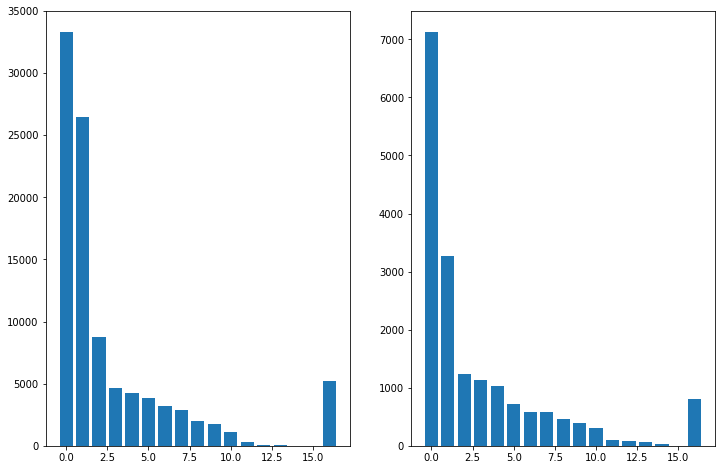

In [8]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,8))

pos = np.arange(len(total_data))
ax1.bar(pos, total_data)
ax2.bar(pos, young_data);

Well, that doesn't look so nice, yet. We need to add some labels and captions, so it becomes clear what we are plotting.

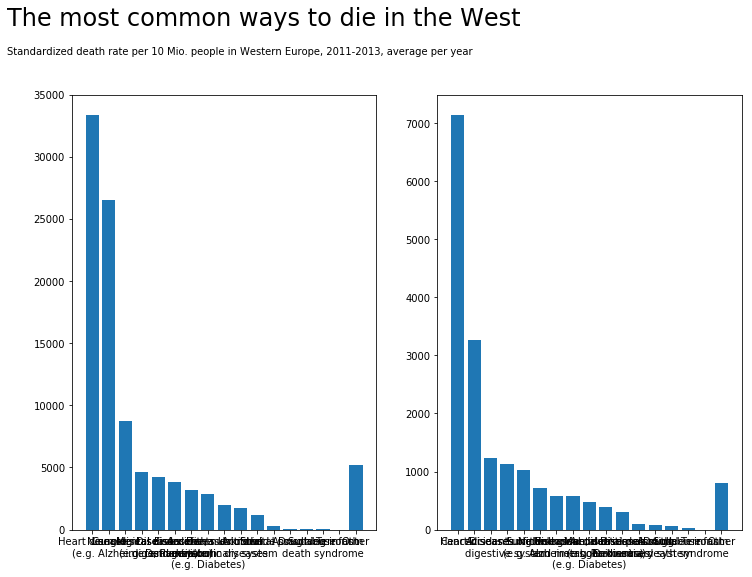

In [9]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,8))
fig.text(s="The most common ways to die in the West",x=0.05,y=1,fontsize=24)
fig.text(s="Standardized death rate per 10 Mio. people "
         "in Western Europe, 2011-2013, average per year",x=0.05,y=.95)
pos = np.arange(len(total_data))

ax1.bar(pos, total_data)
ax1.set_xticks(pos)                   # set tick positions
ax1.set_xticklabels(total_data.index) # set tick labels

ax2.bar(pos, young_data)
ax2.set_xticks(pos)
ax2.set_xticklabels(young_data.index);

Well, these labels are impossible to read, because they overlap. Let's change the orientation of the bar plot to horizontal, so the labels are getting more horizontal space.

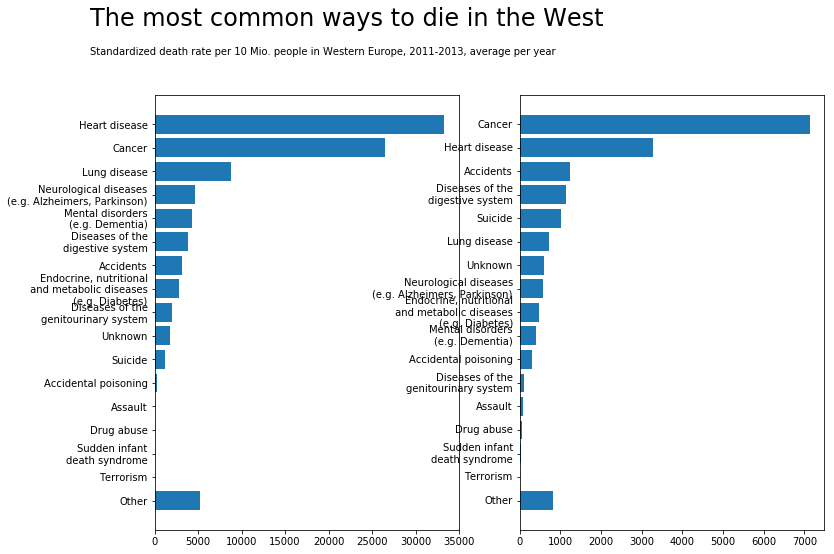

In [10]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,8))
fig.text(s="The most common ways to die in the West",x=0.05,y=1,fontsize=24)
fig.text(s="Standardized death rate per 10 Mio. people "
         "in Western Europe, 2011-2013, average per year",x=0.05,y=.95)
pos = np.arange(len(total_data),0,-1)

# align the center of the bar at the specified locations
ax1.barh(pos, total_data, align="center")  
ax1.set_yticks(pos)                        # set tick positions
ax1.set_yticklabels(total_data.index)      # set tick labels

ax2.barh(pos, young_data, align="center")
ax2.set_yticks(pos)
ax2.set_yticklabels(young_data.index, va="center");

Now the labels are readable, but the two diagrams stil overlap. Actually, there is no real reason to print the labels twice, since both plots show the same thing anyway. We can just combine the two bar plots into one subplot.

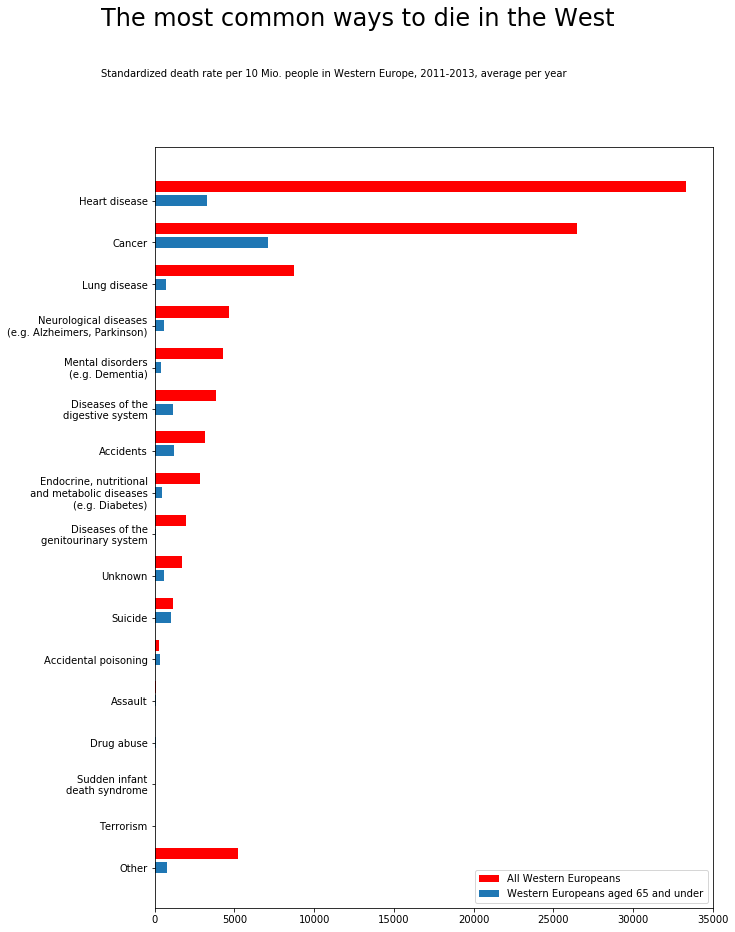

In [11]:
fig, ax = plt.subplots(figsize=(10,14))
fig.text(s="The most common ways to die in the West",x=0.05,y=1,fontsize=24)
fig.text(s="Standardized death rate per 10 Mio. people "
         "in Western Europe, 2011-2013, average per year",x=0.05,y=.95)

# location of total data bars, we need more space now
pos1 = np.arange(3*len(total_data),0,-3) 
ax.barh(pos1, total_data, align="center", color="red", 
        label="All Western Europeans")

pos2 = pos1 - 1 # location of young data bars
ax.barh(pos2, young_data[total_data.index], align="center", 
        label="Western Europeans aged 65 and under")

ax.set_yticks((pos1 + pos2)/2)  # set tick positions between pos1 and pos2 
ax.set_yticklabels(total_data.index)
plt.legend(loc="lower right");  # add a legend

Alright! We have produced a plot that is ugly, but at least readable.

### Make it pretty

My first step towards a pretty plot is to import seaborn. Just by importing this package, calling its ``set`` function, and choosing a different color palette, the plots already become much prettier.

In [12]:
import seaborn as sns
sns.set("talk",style="white")
bar_palette = sns.color_palette("Paired",12,desat=.8)

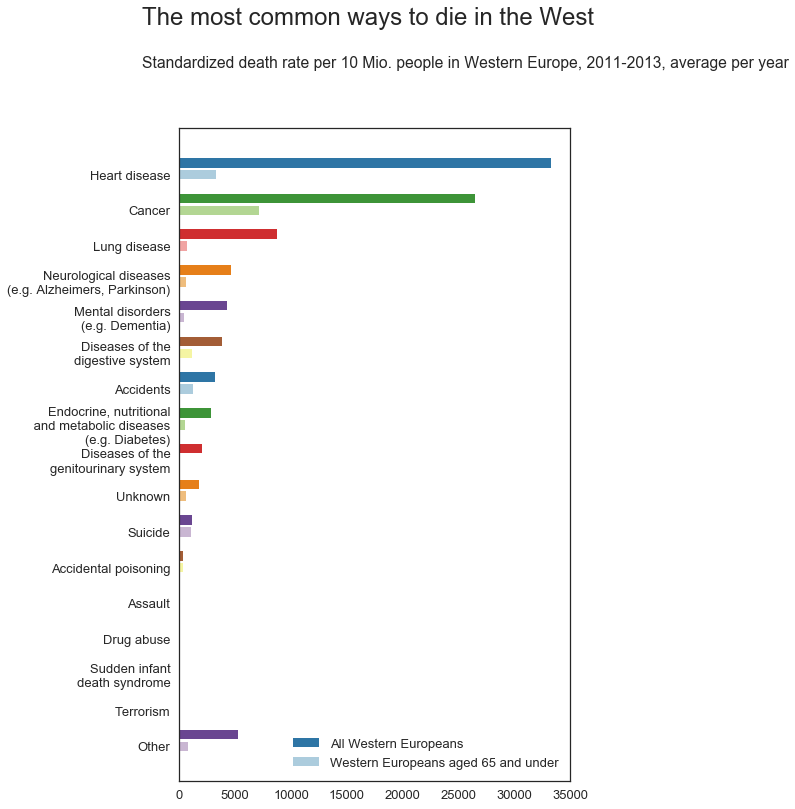

In [13]:
# same code as before, now with seaborn and a color palette!
fig, ax = plt.subplots(figsize=(7,12))
fig.text(s="The most common ways to die in the West",x=0.05,y=1,fontsize=24)
fig.text(s="Standardized death rate per 10 Mio. people "
         "in Western Europe, 2011-2013, average per year",x=0.05,y=.95)

pos1 = np.arange(3*len(total_data),0,-3)
ax.barh(pos1, total_data, align="center", color=bar_palette[1::2], 
        label="All Western Europeans")

pos2 = pos1 - 1 
ax.barh(pos2, young_data[total_data.index], align="center", 
        label="Western Europeans aged 65 and under",
        color=bar_palette[::2])

ax.set_yticks((pos1 + pos2)/2) 
ax.set_yticklabels(total_data.index)
plt.legend(loc="lower right"); 

Seaborn provides an easy way to remove the grid spines at the top and right of the axes (which are not really needed here). I chose to lighten the remaining spines, which is often a good idea if you have big, black lines in your diagram.

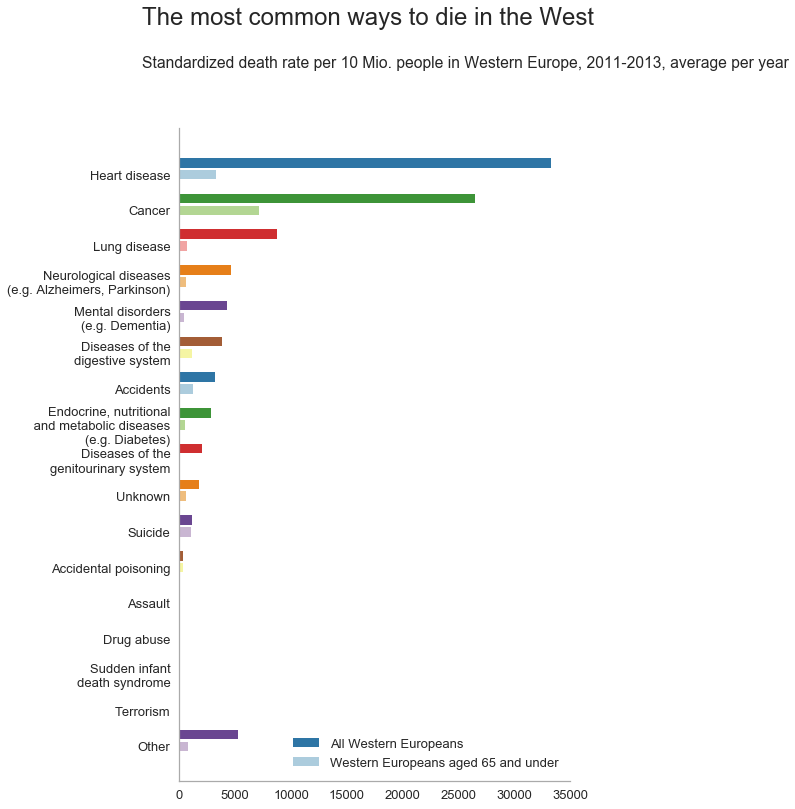

In [14]:
fig, ax = plt.subplots(figsize=(7,12))
fig.text(s="The most common ways to die in the West",x=0.05,y=1,fontsize=24)
fig.text(s="Standardized death rate per 10 Mio. people "
         "in Western Europe, 2011-2013, average per year",x=0.05,y=.95)

pos1 = np.arange(3*len(total_data),0,-3)
ax.barh(pos1, total_data, align="center", color=bar_palette[1::2], 
        label="All Western Europeans")

pos2 = pos1 - 1 
ax.barh(pos2, young_data[total_data.index], align="center", 
        label="Western Europeans aged 65 and under", color=bar_palette[::2])

ax.set_yticks((pos1 + pos2)/2) 
ax.set_yticklabels(total_data.index)
plt.legend(loc="lower right")
sns.despine()
ax.spines['left'].set_edgecolor("#AAAAAA")
ax.spines['bottom'].set_edgecolor("#AAAAAA")

Actually, one of the golden rule of making pretty diagrams is to throw away everything that is unnecessary and might distract the viewer from the data. It would be much nicer to label the bars directly, and remove the bottom axis completely. This can be done via a simple code snippet:

In [15]:
def autolabel(rects):
    """ Attach some text labels to a horizontal bar plot """
    # determine maximum width of the bars, and offset labels by 2% of that
    offset = max([rect.get_width() for rect in rects]) * .02
    for rect in rects:
        width = rect.get_width()
        ax.text(width + offset, rect.get_y() + rect.get_height()/2.,
                "{:.0f}".format(round(width)), # display rounded bar width
                ha='left', va='center',fontsize="x-small")

So, let's despine the figure completely. I have also removed the outline of the bars, giving the diagram a flatter look, and fixed the limits of the y-axis to remove unnecessary whitespace at the top.

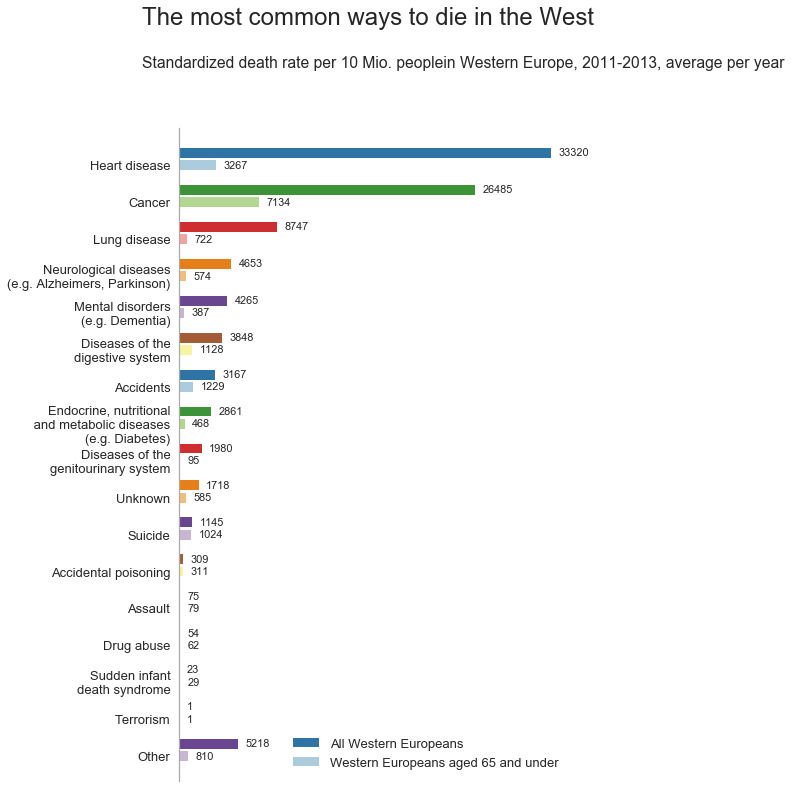

In [16]:
fig, ax = plt.subplots(figsize=(7,12))
fig.text(s="The most common ways to die in the West",x=0.05,y=1,fontsize=24)
fig.text(s="Standardized death rate per 10 Mio. people"
         "in Western Europe, 2011-2013, average per year",x=0.05,y=.95)

pos1 = np.arange(3*len(total_data),0,-3)
bar1 = ax.barh(pos1, total_data, align="center", color=bar_palette[1::2], 
               label="All Western Europeans", linewidth=0)

pos2 = pos1 - 1 
bar2 = ax.barh(pos2, young_data[total_data.index], align="center", 
        label="Western Europeans aged 65 and under",
        color=bar_palette[::2], linewidth=0)

ax.set_yticks((pos1 + pos2)/2) 
ax.set_yticklabels(total_data.index)
plt.legend(loc="lower right")
sns.despine()
ax.spines['left'].set_edgecolor("#AAAAAA")
ax.spines['bottom'].set_visible(False)
ax.xaxis.set_visible(False)
ax.set_ylim((0,pos1[0]+2))

autolabel([rect for rect in bar1] + [rect for rect in bar2])

Some last cosmetics:

- slightly adjust the spacing of the bars
- calling `tight_layout()` to neatly arrange everything inside the figure
- moving the figure title all the way to the left border, and printing it bold
- adding a data source label
- using `subplots_adjust` to make some extra room for the figure title

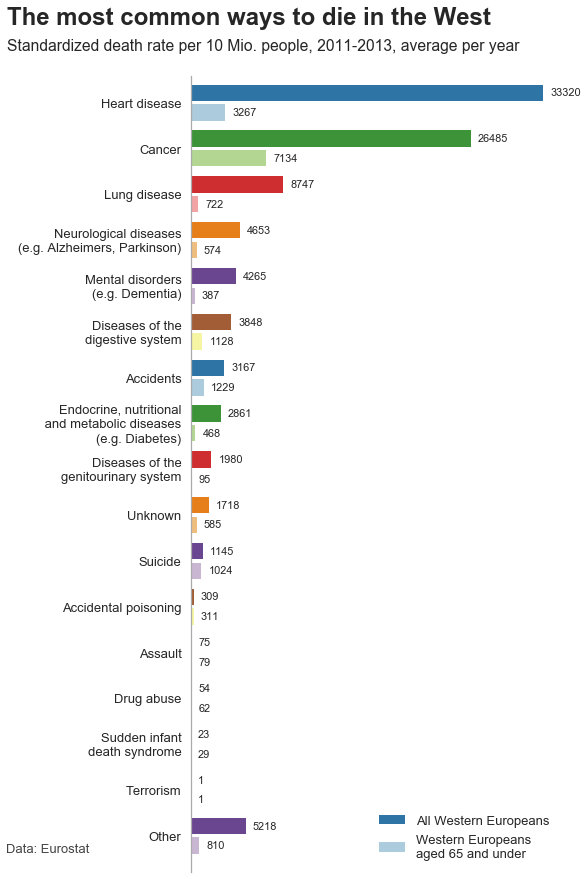

In [17]:
fig, ax = plt.subplots(figsize=(8,12))
fig.text(s="The most common ways to die in the West",x=0.01,y=1,
         fontsize=24,weight="bold",ha="left")
fig.text(s="Standardized death rate per 10 Mio. people, 2011-2013, average per year",
         x=0.01,y=.97,ha="left")

pos1 = np.arange(2.8*len(total_data),0,-2.8)
bar1 = ax.barh(pos1, total_data, align="center", color=bar_palette[1::2], 
               label="All Western Europeans", linewidth=0, height=1)

pos2 = pos1 - 1.2
bar2 = ax.barh(pos2, young_data[total_data.index], align="center", 
                label="Western Europeans\naged 65 and under",
                color=bar_palette[::2], linewidth=0, height=1)

ax.set_yticks((pos1 + pos2)/2) 
ax.set_yticklabels(total_data.index)
plt.legend(loc="lower right")
sns.despine()
ax.spines['left'].set_edgecolor("#AAAAAA")
ax.spines['bottom'].set_visible(False)
ax.xaxis.set_visible(False)
ax.set_ylim((0,pos1[0]+1))

autolabel([rect for rect in bar1] + [rect for rect in bar2])
plt.annotate("Data: Eurostat", (.01,.03), xycoords = "figure fraction",
             fontsize="small", color="#444444")
fig.tight_layout()
fig.subplots_adjust(top=.94)
# create a figure that measures about 500px in width
fig.savefig("deaths-bar.png",bbox_inches="tight",transparent=True,dpi=500/8)

Ta-da! Looks nice, doesn't it? If you want, you can play around a bit - it could be nice to use a different color scheme, or to have a light grid in the background, so it becomes easier to compare values. Also, I'm not entirely happy with the different scales on the two data sets - this way, the difference in relative importance of e.g. cancer and suicide isn't really striking the viewer.